## 掛載雲端硬碟


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 更改檔案所在路徑

In [ ]:
# Change to your own folder !!!
%cd /content/drive/MyDrive/your own folder/

## Import library

In [1]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models.resnet import ResNet50

## FLOPs & Parameters & Architecture
若`resnet.py`有寫對，這部分會能夠正常跑，且 parameters 應為 23513162。

你也可以寫一個剪枝後可能的 cfg 作為模型的輸入參數，看這部分印出來的架構是否正確。

In [ ]:
!pip install thop
!pip install torchsummary

In [2]:
from thop import profile
from torchsummary import summary

model = ResNet50(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 328947712.0
Params: 23513162.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]          

## 設定超參數(請填空 λ)

In [3]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-4

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000

EPOCHS = 40
LEARNING_RATE = 1e-3

LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = 'bestmodel/model_best.pth' # Change to your own folder !!!

In [4]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [5]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

## 定義模型與設定Optimizer & CrossEntropy Loss


In [6]:
model = ResNet50(num_classes=10)
if CUDA:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## 使用論文中稀疏化的方式更新參數(請填空)

 1. $ \frac{\partial Loss}{\partial \gamma old} +\frac{\partial(\lambda\sum g(\gamma))}{\partial \gamma old} $ <br>
 2. $ g(γ)=∣γ∣ $
3. 所以 $ \frac{\partial(\lambda\sum g(\gamma))}{\partial \gamma old} = \frac{\partial(\lambda\sum|\gamma|)}{\partial \gamma old} $
4. torch.sign(m.weight.data) ->把每個weight變+1 or -1

In [7]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          ################################################

          m.weight.grad.data.add_(LAMBDA*torch.sign(m.weight.data))

## 定義訓練跟測試函數
需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

In [8]:
#### 訓練函數 #####
train_acc = []
test_acc = []
# 注意: 需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

def train(epoch):
    model.train()
    accuracy_per_batch = []
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

        correct = pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy = correct / float(len(data))
        accuracy_per_batch.append(accuracy)
    train_acc.append(sum(accuracy_per_batch)/len(accuracy_per_batch))

#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)

          output = model(data)
          loss = criterion(output, target)
          test_loss += loss.item() * data.size(0)

          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      test_acc.append(correct/float(len(test_loader.dataset)))
      return correct / float(len(test_loader.dataset))

##########################################################################################

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        best_prec1 = prec1
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.426045
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.959687
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.925859
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.631376
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.637270

Test set: Average loss: 1.5563, Accuracy: 4425/10000 (44.2%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.561793
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.431808
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.457864
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 1.375774
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 1.518061

Test set: Average loss: 1.4970, Accuracy: 5423/10000 (54.2%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 1.269139
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 1.336648
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 1.225727
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 1.100623
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 1.144632

Test set: Average loss: 1.2568, Accuracy: 5716/10000 (57.2%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 1.020955

## 繪製Sparsity-Training結果圖

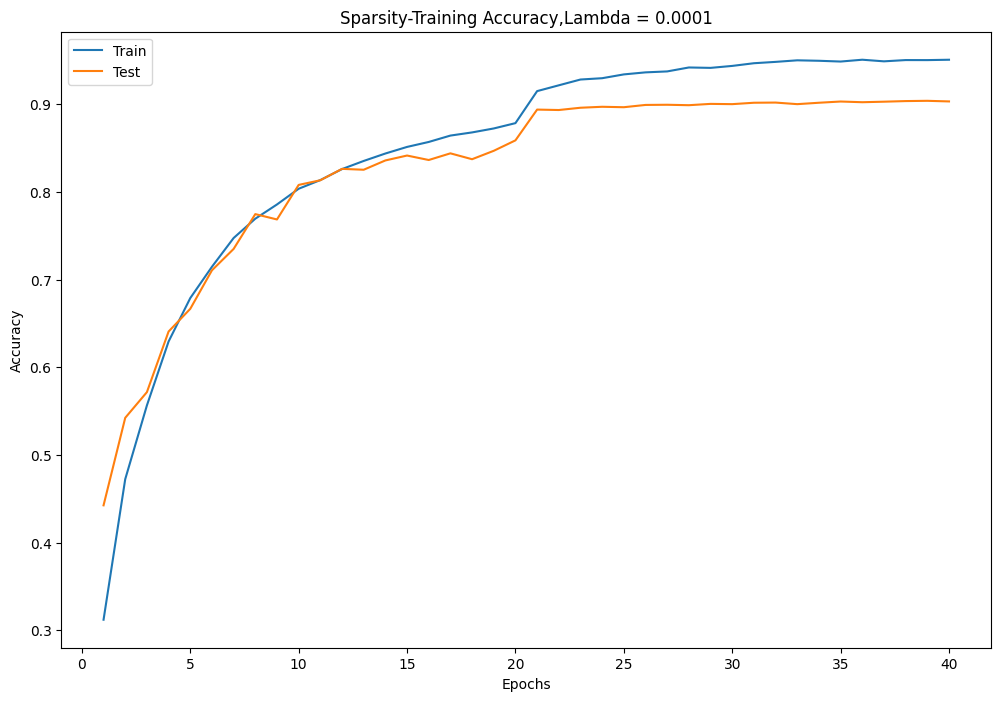

In [9]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, EPOCHS+1), train_acc, label='Train')
plt.plot(np.arange(1, EPOCHS+1), test_acc, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Sparsity-Training Accuracy,Lambda = {LAMBDA}')
plt.legend()
plt.savefig(f'result/train_accuracy_{LAMBDA}.png')
plt.show()

## 繪製scaling factor 分布圖

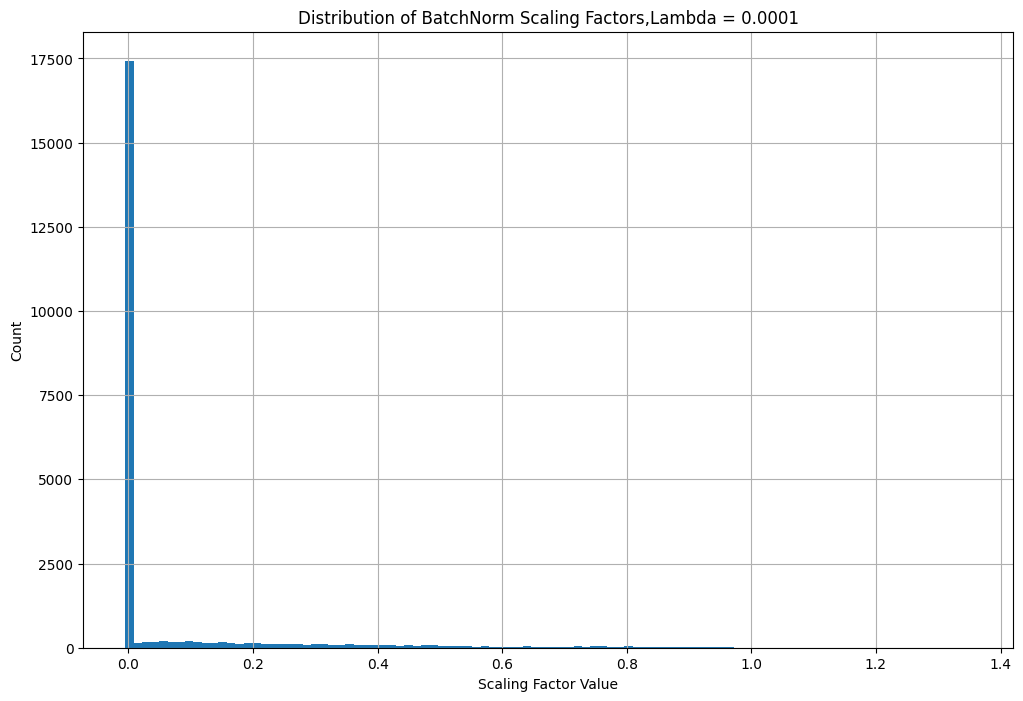

In [10]:
#繪製 scaling factor 分布圖
scaling_factor_list = []

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        scaling_factor = m.weight.data.cpu().numpy()
        # print(scaling_factor.shape) 
        scaling_factor_list.extend(scaling_factor)


plt.figure(figsize=(12, 8))
plt.hist(scaling_factor_list, bins=100)
plt.title(f'Distribution of BatchNorm Scaling Factors,Lambda = {LAMBDA}')
plt.xlabel('Scaling Factor Value')
plt.ylabel('Count')
plt.grid()
plt.savefig(f'result/scaling_factor_{LAMBDA}.png')
plt.show()